<a href="https://colab.research.google.com/github/VikriAulia/Tensorflow-Deep-Learning-Speech-Recognition/blob/master/Speech_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the required libraries

In [0]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import *
from sklearn.metrics import confusion_matrix
from fnmatch import fnmatch
import pandas as pd
import os
%load_ext tensorboard
RUN = 1

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
from keras import regularizers
import os
RawData = '/content/RawData/SpeechEmotion/'

In [0]:
!ls /content/drive/My\ Drive/Dataset/Speech/SpeechEmotion/

SpeechEmotion.zip


In [0]:
#!unzip -q /content/drive/My\ Drive/Dataset/Speech/SpeechEmotion/SpeechEmotion.zip -d RawData 

In [0]:
def getlistOfFiles(dirName):
  allFiles = list()
  for path, subdirs, files in os.walk(dirName):
    for name in files:
        if fnmatch(name, '*.wav'):
            allFiles.append(name)
  return allFiles

In [0]:
mylist= getlistOfFiles(RawData)

In [0]:
print(type(mylist))
print(len(mylist))

<class 'list'>
2932


In [0]:
print(mylist[1400])

03-01-06-02-02-01-18.wav


In [0]:
print(mylist[400][6:-16])

## Plotting the audio file's waveform and its spectrogram

In [0]:
data, sampling_rate = librosa.load(RawData+'a01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


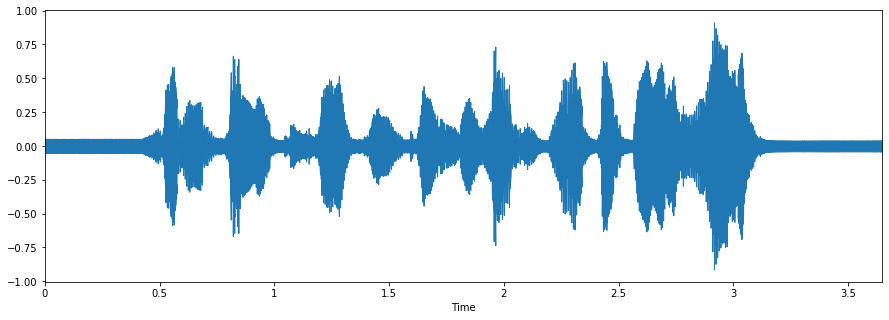

In [0]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

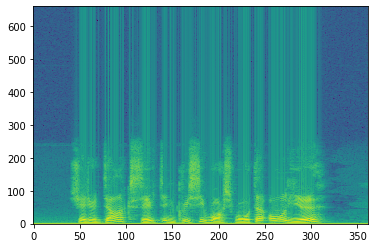

In [0]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read(RawData+'a01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [0]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='01' and int(item[18:-4])%2==1:
        feeling_list.append('male_neutral')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='01' and int(item[18:-4])%2==0:
        feeling_list.append('female_neutral')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[6:-16]=='07' and int(item[18:-4])%2==0:
        feeling_list.append('female_disgust')
    elif item[6:-16]=='07' and int(item[18:-4])%2==1:
        feeling_list.append('male_disgust')
    elif item[6:-16]=='08' and int(item[18:-4])%2==0:
        feeling_list.append('female_surprise')
    elif item[6:-16]=='08' and int(item[18:-4])%2==1:
        feeling_list.append('male_surprise')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='d':
        feeling_list.append('male_disgust')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    elif item[:1]=='n':
        feeling_list.append('male_neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')
    elif item[:2]=='su':
        feeling_list.append('male_surprise')
    else:
      print(item)

In [0]:
labels = pd.DataFrame(feeling_list)

In [0]:
len(labels)

2932

In [0]:
len(mylist)

2932

## Getting the features of audio files using librosa

In [0]:
df = pd.DataFrame(columns=['feature'])
for index,y in enumerate(mylist):
  X, sample_rate = librosa.load(RawData+y, res_type='kaiser_fast',duration=3, sr=16000, offset=0.5)
  sample_rate = np.array(sample_rate)
  mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                       sr=sample_rate, 
                                       n_mfcc=80),
                  axis=0)
  feature = mfccs
  #[float(i) for i in feature]
  #feature1=feature[:135]
  df.loc[index] = [-(feature/100)]     

In [0]:
df[:5]

,feature
0,"[0.21959577425048837, 0.2181411088205795, 0.22..."
1,"[0.23525697032866336, 0.2336867889203647, 0.23..."
2,"[0.2248440033157117, 0.23155891202058615, 0.23..."
3,"[0.17070355746277663, 0.17506442792588722, 0.1..."
4,"[0.3170972696806213, 0.325148623667544, 0.3281..."


In [0]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [0]:
newdf = pd.concat([df3,labels], axis=1)

In [0]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [0]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,0
0,0.219596,0.218141,0.222578,0.224496,0.226723,0.226840,0.232489,0.227145,0.224495,0.230511,0.231718,0.227994,0.228186,0.235368,0.225440,0.213259,0.165485,0.144186,0.162060,0.185666,0.178073,0.172523,0.182405,0.202951,0.203707,0.187431,0.176185,0.163315,0.155169,0.156852,0.135150,0.129931,0.131984,0.143867,0.154743,0.150040,0.164260,0.163218,0.174176,0.183813,...,0.140767,0.141476,0.152329,0.162510,0.163140,0.155835,0.152994,0.154532,0.152391,0.147547,0.156818,0.173828,0.193011,0.211721,0.214321,0.220202,0.221918,0.224585,0.228761,0.219342,0.219806,0.231655,0.232855,0.228417,0.235015,0.237194,0.257621,0.254966,0.249592,0.245326,0.239110,0.232827,0.228762,0.230838,0.234728,0.235807,0.243135,0.240377,0.244784,male_calm
1,0.235257,0.233687,0.237380,0.233337,0.224867,0.217387,0.227543,0.230219,0.225384,0.224863,0.234932,0.245076,0.247530,0.251612,0.251893,0.224916,0.201155,0.177291,0.179658,0.177019,0.179822,0.175575,0.159295,0.163568,0.158668,0.161198,0.172672,0.168672,0.168014,0.166720,0.169701,0.160799,0.162102,0.173854,0.184747,0.194432,0.189793,0.191022,0.195796,0.193094,...,0.198397,0.197036,0.193709,0.189745,0.173853,0.167256,0.177644,0.176672,0.177118,0.183297,0.171639,0.166645,0.172171,0.177812,0.190978,0.194543,0.194646,0.195625,0.195396,0.195411,0.193992,0.187751,0.191928,0.174562,0.164932,0.168050,0.172145,0.175934,0.175988,0.180621,0.186013,0.176267,0.176005,0.179614,0.168581,0.169582,0.176592,0.179216,0.129751,female_neutral
2,0.224844,0.231559,0.239072,0.244965,0.247067,0.252071,0.264345,0.262257,0.273898,0.281482,0.276656,0.282351,0.288244,0.293866,0.313522,0.297198,0.284350,0.260742,0.248413,0.247493,0.252822,0.257025,0.254996,0.253736,0.253448,0.269607,0.267611,0.266266,0.263678,0.251040,0.249557,0.249397,0.238957,0.219324,0.218377,0.209540,0.205560,0.198672,0.214926,0.227403,...,0.286842,0.238792,0.206398,0.183323,0.179201,0.183504,0.206815,0.210172,0.215472,0.223080,0.227423,0.207487,0.200579,0.211933,0.226010,0.224407,0.228440,0.226676,0.233897,0.246605,0.250341,0.239086,0.224982,0.219161,0.217494,0.221829,0.220850,0.219545,0.221615,0.223702,0.238375,0.243621,0.244837,0.254171,0.250824,0.240074,0.241457,0.242013,0.196708,female_fearful
3,0.170704,0.175064,0.181991,0.184794,0.184616,0.186348,0.180025,0.178469,0.185488,0.187279,0.195625,0.202672,0.199299,0.162869,0.155618,0.156388,0.102027,0.054366,0.031378,0.026762,0.038604,0.049768,0.078191,0.101576,0.118773,0.137950,0.110240,0.088300,0.077853,0.091026,0.101513,0.104084,0.094444,0.065342,0.014348,-0.006118,0.006236,0.047604,0.081426,0.099396,...,0.089023,0.084618,0.072679,0.075215,0.062188,0.052780,0.067355,0.051562,0.059470,0.070567,0.043639,0.054403,0.096512,0.123265,0.131469,0.125045,0.134827,0.147126,0.157224,0.165954,0.163443,0.172243,0.172557,0.155930,0.141783,0.134371,0.120274,0.105845,0.091495,0.091341,0.098065,0.104044,0.107111,0.114693,0.113286,0.129327,0.127651,0.124776,0.109518,male_angry
4,0.317097,0.325149,0.328185,0.328185,0.328185,0.326199,0.317035,0.319110,0.328185,0.328185,0.328185,0.283857,0.252049,0.220340,0.202377,0.163081,0.126613,0.125458,0.130346,0.147525,0.160326,0.160790,0.160475,0.162081,0.166887,0.161970,0.160233,0.159986,0.166483,0.167594,0.159371,0.166450,0.175791,0.195179,0.197365,0.196694,0.194589,0.187590,0.186839,0.181401,...,0.195742,0.182830,0.177555,0.167414,0.153103,0.151504,0.153698,0.169565,0.192190,0.208621,0.216432,0.222804,0.243792,0.243147,0.243071,0.250795,0.268365,0.297441,0.291233,0.301786,0.313198,0.316252,0.319471,0.279629,0.263531,0.274929,0.282184,0.297757,0.317551,0.299248,0.301150,0.268136,0.233053,0.206781,0.161435,0.142790,0.148353,NaN,NaN,male_fearful


In [0]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,0
700,0.319034,0.322380,0.326039,0.327756,0.318615,0.320140,0.326671,0.327756,0.327756,0.327756,0.327756,0.327756,0.322188,0.312476,0.313314,0.288911,0.253129,0.241804,0.246678,0.257083,0.267786,0.264714,0.259141,0.265800,0.247189,0.231014,0.223038,0.220631,0.226467,0.224453,0.231577,0.237938,0.239823,0.233428,0.218730,0.216833,0.230470,0.243289,0.250162,0.250014,...,0.196079,0.209792,0.227016,0.220464,0.227242,0.236401,0.244010,0.267039,0.264291,0.259527,0.265395,0.262980,0.257454,0.251959,0.244525,0.245559,0.241402,0.235737,0.228440,0.230702,0.242856,0.222123,0.215174,0.215335,0.204699,0.193753,0.193078,0.193571,0.195987,0.206497,0.221266,0.230901,0.240379,0.237632,0.234114,0.231177,0.238266,0.255915,0.255028,female_calm
2524,0.287980,0.287980,0.287260,0.285333,0.281244,0.264867,0.256550,0.252222,0.242144,0.234314,0.237910,0.229177,0.225021,0.228088,0.231539,0.234294,0.236600,0.225323,0.216891,0.203547,0.195548,0.202767,0.203648,0.201770,0.202928,0.162640,0.152163,0.151316,0.145874,0.148242,0.154055,0.154815,0.168566,0.186578,0.193708,0.169401,0.175863,0.180634,0.193669,0.196580,...,0.173574,0.181816,0.178106,0.174521,0.171261,0.182131,0.187775,0.197532,0.191615,0.164021,0.155920,0.170592,0.177088,0.185247,0.193498,0.197749,0.190360,0.194578,0.192624,0.188152,0.197208,0.195081,0.198933,0.218701,0.226625,0.241357,0.248875,0.264533,0.265250,0.275168,0.271948,0.249271,0.243280,0.241517,0.237659,0.235378,0.231866,0.236992,0.245009,female_happy
2102,0.302513,0.302513,0.302513,0.302513,0.302513,0.302513,0.302513,0.302513,0.302513,0.302513,0.302513,0.301970,0.266229,0.236225,0.231145,0.176237,0.152559,0.160001,0.178658,0.203444,0.201029,0.206646,0.240673,0.236994,0.200158,0.172000,0.157932,0.163965,0.181367,0.194665,0.185877,0.179569,0.178385,0.178878,0.196358,0.205886,0.198862,0.189437,0.186039,0.183802,...,0.207379,0.206520,0.216895,0.235805,0.239466,0.254450,0.246686,0.253761,0.250825,0.246065,0.255165,0.262637,0.257292,0.268649,0.268962,0.257274,0.252384,0.247393,0.247613,0.247847,0.245675,0.255927,0.264904,0.252655,0.253155,0.261922,0.259510,0.258200,0.274362,0.285214,0.288564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_surprise
1793,0.247774,0.260018,0.256191,0.257927,0.263879,0.270902,0.273950,0.274588,0.277054,0.276824,0.275806,0.278010,0.278769,0.278769,0.278769,0.273616,0.255996,0.233764,0.235119,0.210034,0.179396,0.170724,0.171099,0.174765,0.188913,0.199581,0.201897,0.197840,0.200577,0.196064,0.204654,0.193655,0.188238,0.188274,0.171022,0.164107,0.176012,0.157585,0.130019,0.117822,...,0.173394,0.159213,0.132100,0.129643,0.152356,0.167646,0.183264,0.188508,0.175893,0.187723,0.209923,0.173514,0.134464,0.136622,0.171524,0.188829,0.170417,0.170204,0.168874,0.160325,0.158732,0.164488,0.146816,0.151102,0.166205,0.181858,0.192529,0.207324,0.211629,0.221784,0.234966,0.250133,0.255430,0.256354,0.258479,0.264911,0.272215,0.270977,0.261730,female_fearful
2306,0.201795,0.196618,0.194951,0.198814,0.193843,0.188347,0.192044,0.200351,0.204459,0.208246,0.209414,0.199130,0.202219,0.208336,0.207559,0.184773,0.171620,0.151112,0.103849,0.067682,0.034825,0.029203,0.046208,0.061930,0.063003,0.064296,0.071906,0.032328,-0.013658,-0.034678,-0.034415,-0.012315,0.017425,0.038708,0.059655,0.088533,0.136638,0.162714,0.125579,0.072629,...,0.094811,0.060237,0.025690,0.012079,0.022301,0.035409,0.037453,0.050815,0.064344,0.085735,0.093829,0.102239,0.109746,0.123794,0.138266,0.133370,0.131543,0.130538,0.129406,0.136607,0.139210,0.141917,0.151177,0.150871,0.149323,0.153467,0.159258,0.170277,0.167001,0.168120,0.167172,0.169594,0.169390,0.169552,0.172404,0.174826,0.183123,0.186376,0.190327,male_fearful
1496,0.281848,0.281848,0.281875,0.279513,0.278747,0.281418,0.280795,0.280069,0.279119,0.279844,0.280977,0.281976,0.281848,0.281848,0.281

In [0]:
rnewdf=rnewdf.fillna(0)
#rnewdf=rnewdf.dropna()

In [0]:
len(rnewdf)

2932

## Dividing the data into test and train

In [0]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [0]:
train = shuffle(train)
train[260:270]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,0
282,0.282346,0.283518,0.288263,0.285537,0.279657,0.279764,0.285293,0.287995,0.289589,0.292292,0.293783,0.298155,0.299754,0.299754,0.293954,0.291277,0.296509,0.257854,0.232113,0.222248,0.203214,0.181020,0.171535,0.162726,0.167158,0.192255,0.206811,0.204919,0.209457,0.214585,0.221619,0.239927,0.251660,0.264093,0.269420,0.258944,0.262790,0.273645,0.272723,0.271886,...,0.140029,0.168407,0.188799,0.215257,0.221142,0.228912,0.237030,0.218023,0.192330,0.195067,0.214508,0.225217,0.234614,0.244167,0.245977,0.259184,0.280454,0.279838,0.261594,0.239487,0.224329,0.221960,0.224506,0.235235,0.228596,0.217937,0.204428,0.205484,0.208758,0.217362,0.213301,0.211007,0.219374,0.232177,0.248928,0.253154,0.241152,0.242545,0.253133,female_disgust
1355,0.319009,0.312529,0.308303,0.303135,0.298077,0.299077,0.330968,0.337435,0.305662,0.290408,0.284914,0.251640,0.195282,0.174693,0.177186,0.198945,0.203640,0.183584,0.174643,0.187009,0.182476,0.182234,0.183866,0.185791,0.188525,0.177719,0.181326,0.190798,0.190107,0.181371,0.187176,0.181119,0.148935,0.148486,0.175944,0.200143,0.183413,0.171923,0.169781,0.177055,...,0.200527,0.211457,0.223050,0.244079,0.269148,0.265042,0.271472,0.286822,0.303106,0.296164,0.287560,0.217165,0.181272,0.177916,0.170978,0.167184,0.169327,0.162271,0.168580,0.180855,0.173658,0.176297,0.198536,0.201273,0.196781,0.182472,0.174407,0.183849,0.199371,0.208032,0.207205,0.215236,0.199373,0.206677,0.226394,0.230526,0.238937,0.264064,0.274748,male_sad
0,0.219596,0.218141,0.222578,0.224496,0.226723,0.226840,0.232489,0.227145,0.224495,0.230511,0.231718,0.227994,0.228186,0.235368,0.225440,0.213259,0.165485,0.144186,0.162060,0.185666,0.178073,0.172523,0.182405,0.202951,0.203707,0.187431,0.176185,0.163315,0.155169,0.156852,0.135150,0.129931,0.131984,0.143867,0.154743,0.150040,0.164260,0.163218,0.174176,0.183813,...,0.140767,0.141476,0.152329,0.162510,0.163140,0.155835,0.152994,0.154532,0.152391,0.147547,0.156818,0.173828,0.193011,0.211721,0.214321,0.220202,0.221918,0.224585,0.228761,0.219342,0.219806,0.231655,0.232855,0.228417,0.235015,0.237194,0.257621,0.254966,0.249592,0.245326,0.239110,0.232827,0.228762,0.230838,0.234728,0.235807,0.243135,0.240377,0.244784,male_calm
2407,0.242013,0.235098,0.222476,0.211019,0.203873,0.205829,0.208749,0.220847,0.237278,0.231153,0.231245,0.246371,0.264587,0.254173,0.233065,0.199923,0.152681,0.143239,0.139487,0.151443,0.162690,0.164751,0.148892,0.162675,0.171848,0.186509,0.169910,0.169533,0.195793,0.210411,0.196710,0.177852,0.177553,0.183758,0.182542,0.188382,0.206970,0.230618,0.218108,0.176583,...,0.103375,0.075755,0.087397,0.120811,0.142835,0.145524,0.137245,0.123140,0.127997,0.133202,0.148779,0.156796,0.161921,0.165511,0.185058,0.200186,0.209108,0.224498,0.231994,0.234727,0.225715,0.212253,0.213823,0.221173,0.235465,0.250406,0.245140,0.251633,0.257540,0.238294,0.231429,0.223278,0.212997,0.214890,0.217454,0.217764,0.219560,0.234078,0.232227,male_angry
440,0.092120,0.078028,0.079296,0.081159,0.075853,0.072464,0.069064,0.073780,0.070007,0.071757,0.074439,0.069633,0.064064,0.060535,0.070306,0.076775,0.077919,0.071164,0.067708,0.060423,0.061001,0.064304,0.061263,0.064988,0.070728,0.080769,0.083826,0.090659,0.098074,0.077521,0.070914,0.069581,0.064857,0.056295,0.056226,0.053387,0.052639,0.059401,0.068655,0.081978,...,0.070512,0.056182,0.056976,0.074264,0.093544,0.112213,0.109381,0.113070,0.098036,0.094370,0.090036,0.096746,0.093450,0.096369,0.103849,0.110008,0.107315,0.109359,0.103976,0.104236,0.106330,0.109540,0.111668,0.111560,0.108633,0.112681,0.102177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2007,0.331941,0.330328,0.328245,0.317444,0.309348,0.314692,0.338841,0.323564,0.295368,0.284807,0.278216,0.294830,

In [0]:
trainfeatures = train.iloc[:, :-1]

In [0]:
trainlabel = train.iloc[:, -1:]

In [0]:
testfeatures = test.iloc[:, :-1]

In [0]:
testlabel = test.iloc[:, -1:]

In [0]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
X_train.shape

(2281, 94)

## Changing dimension for CNN model

In [0]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [0]:
x_traincnn.shape

(2281, 94, 1)

In [0]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(94,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Dense(64))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 94, 128)           768       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 94, 128)           82048     
_________________________________________________________________
activation_2 (Activation)    (None, 94, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 128)          

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [0]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.2
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate

In [0]:
def dotrain():
  global RUN
  RUN+=1
  print("RUN {}".format(RUN))
  LOG_DIR = '/content/drive/My Drive/Model/speechEmotion/output/training_logs/run-{}'.format(RUN)
  LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

  tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=1, write_grads=False, write_graph=False)
  #tensorboard = TensorBoard(log_dir=LOG_DIR, write_graph=True)
  checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
  lrate = LearningRateScheduler(step_decay)
  history=model.fit(x_traincnn, 
                       y_train, 
                       batch_size=32, 
                       epochs=1000, 
                       validation_data=(x_testcnn, y_test),
                       callbacks=[tensorboard, checkpoint, early_stopping, lrate])
  return history

In [0]:
print(len(x_traincnn))

2281


In [0]:
cnnhistory = dotrain()

RUN 2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2281 samples, validate on 651 samples








Epoch 1/1000
Changing learning rate to 0.001
2281/2281 [==============================] - 3s 1ms/step - loss: 2.7204 - acc: 0.0886 - val_loss: 2.6425 - val_acc: 0.0983


Epoch 00001: val_loss improved from inf to 2.64249, saving model to /content/drive/My Drive/Model/speechEmotion/output/training_logs/run-2/checkpoint-01-2.6425.hdf5
Epoch 2/1000
Changing learning rate to 0.001
2281/2281 [==============================] - 1s 409us/step - loss: 2.5772 - acc: 0.1271 - val_loss: 2.5050 - val_acc: 0.1551

Epoch 00002: val_loss improved from 2.64249 to 2.50496, saving model to /content/drive/My Drive/Model/speechEmotion/output/training_logs/run-2/checkpoint-02-2.5050.hdf5
Epoch 3/1000
Changing learning rate to 0.001
2281/2281 [==============================] - 1s 441us/step - loss: 2.5019 - acc: 0.1495 - val_loss: 2.4560 - val_acc: 0.16

In [0]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [0]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [0]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [0]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

## Predicting emotions on the test data

In [0]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

In [0]:
preds

In [0]:
preds1=preds.argmax(axis=1)

In [0]:
preds1

In [0]:
abc = preds1.astype(int).flatten()

In [0]:
predictions = (lb.inverse_transform((abc)))

In [0]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [0]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [0]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [0]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [0]:
finaldf[170:180]

In [0]:
finaldf.groupby('actualvalues').count()

In [0]:
finaldf.groupby('predictedvalues').count()

In [0]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [0]:
data, sampling_rate = librosa.load('output10.wav')

In [0]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [0]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [0]:
livedf2= pd.DataFrame(data=livedf2)

In [0]:
livedf2 = livedf2.stack().to_frame().T

In [0]:
livedf2

In [0]:
twodim= np.expand_dims(livedf2, axis=2)

In [0]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

In [0]:
livepreds

In [0]:
livepreds1=livepreds.argmax(axis=1)

In [0]:
liveabc = livepreds1.astype(int).flatten()

In [0]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions